In [1]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer 
import pickle

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict 
import random
from pathlib import Path
from PIL import Image
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.io import read_image
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision import transforms
#from tqdm.auto import tqdm
#from torchvision.transforms.v2 import SanitizeBoundingBox as SBox


print(f'PyTorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

# https://medium.com/@anumolcs1996/image-gradient-for-edge-detection-in-pytorch-a9498a7827d6
# https://pytorch.org/vision/main/transforms.html
# https://pytorch.org/docs/stable/optim.html
# https://pytorch.org/docs/stable/nn.html

PyTorch version: 2.0.1
torchvision version: 0.15.2


In [2]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
random.seed(42)

In [3]:
img_class_name = {0:'clean', 1:'dirty'}
img_class_name_inverse = {'clean':0, 'dirty':1}

In [4]:
img_partition = {0:'train', 1:'test', 2:'hidden'}
img_partition_inverse = {'train':0, 'test':1, 'hidden':2}

In [5]:
class CudaHelper:
    
    def get_device():
        device = "cuda" if torch.cuda.is_available() else "cpu"
        #device = 'cpu'
        return device

In [6]:
class ImageItem:
    
    def __init__(self, image:torch.Tensor, full_path:str, image_class:int, image_partition:int):
        self.image = image
        self.full_path = full_path
        self.image_class = image_class
        self.image_partition = image_partition
    
    def stringify(self):
        return f'Class: {img_class_name[self.image_class]}:{self.image_class}. Partition: {img_partition[self.image_partition]}'

In [7]:
class ImageHelper:
    
    def plot_tensor(img:torch.Tensor):
        img_cpu = img.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.show()
    
    def plot_img(img:ImageItem):
        img_cpu = img.image.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.title(f'{img.stringify()}')
        plt.show()
    
    def do_load(data_dir:str, partition:str, class_name:str) -> List[ImageItem]:
        all_files = os.listdir(data_dir)
        all_images = []

        for f in all_files:
            full_path = os.path.join(data_dir, f)
            img_tensor = read_image(full_path).to(CudaHelper.get_device())
            ii = ImageItem(img_tensor, full_path, img_class_name_inverse[class_name], img_partition_inverse[partition])
            all_images.append(ii)
        
        return all_images
    
    def load_images(base_dir:str, partition:str) -> List[ImageItem]:        
        cleans = ImageHelper.do_load(os.path.join(base_dir, partition, 'clean'), partition, 'clean')
        dirtys = ImageHelper.do_load(os.path.join(base_dir, partition, 'dirty'), partition, 'dirty')
        return cleans, dirtys
    
    def gradient_transform(img:torch.Tensor):
        img = img.squeeze(0)
        ten=torch.unbind(img)
        x=ten[0].unsqueeze(0).unsqueeze(0)

        a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight=nn.Parameter(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0))
        G_x=conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight=nn.Parameter(torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0))
        G_y=conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
        return G


In [8]:
class ImageTransformer:
    
    def plot_transformed_images(image_items:List[ImageItem], transform, n=3):

        random_image_items = random.sample(image_items, k=n)
        
        for item in random_image_items:
            with Image.open(item.full_path) as f:

                # original
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(f) 
                ax[0].set_title(f"Original \nSize: {f.size}")
                ax[0].axis("off")

                # transformed
                transformed_image = transform(f).permute(1, 2, 0) 
                ax[1].imshow(transformed_image) 
                ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
                ax[1].axis("off")

                fig.suptitle(f"{item.stringify()}", fontsize=16)

In [9]:
class ModelHelper:
    
    def print_model_info(model:nn.Module):
        print(model)
    
    def print_model_info_full(model:nn.Module):
        print(summary(model, input_size=[1, 3, 64, 64]))
    
    def print_model_custom_cols(model:nn.Module):
        print(summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]))
                

## Print several random images

In [10]:
main_dir = 'C:\\Users\\Valentine\\Downloads\\NeuralNetworks\\plates\\plates\\'

clean_train, dirty_train = ImageHelper.load_images(main_dir, 'train')
clean_test, dirty_test = ImageHelper.load_images(main_dir, 'test')
clean_hidden, dirty_hidden = ImageHelper.load_images(main_dir, 'hidden')

In [11]:
_ALL_ITEMS_ = [*clean_train, *dirty_train, *clean_test, *dirty_test, *clean_hidden, *dirty_hidden]
_TRAIN_ = [*clean_train, *dirty_train, *clean_test, *dirty_test]
_ALL_PATHS_ = [i.full_path for i in _ALL_ITEMS_]

In [12]:
transforms.RandomHorizontalFlip(p=0.5)

RandomHorizontalFlip(p=0.5)

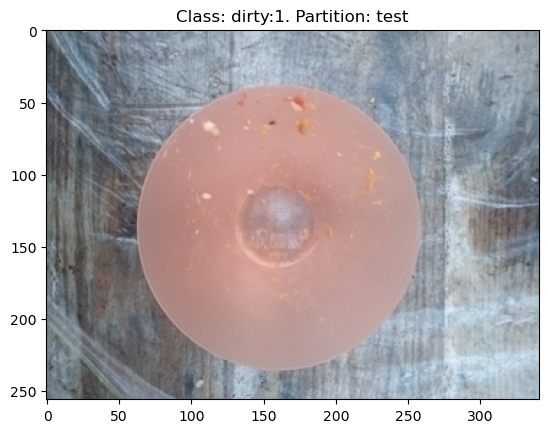

In [13]:
ImageHelper.plot_img(random.choice(_ALL_ITEMS_))

## Do image augmentation 

In [14]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
])

simple_transform_no_tensor = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [15]:
full_transform =transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor()
])

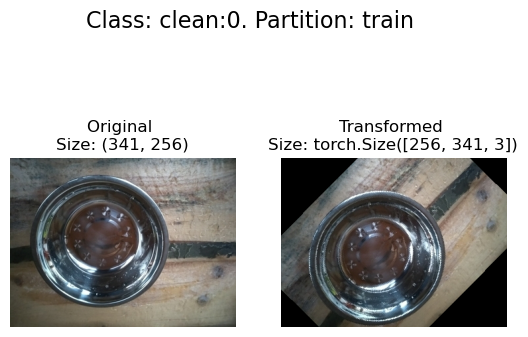

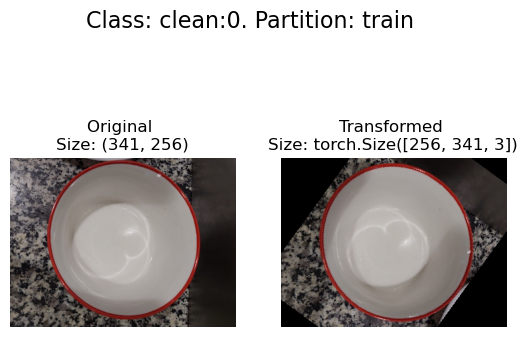

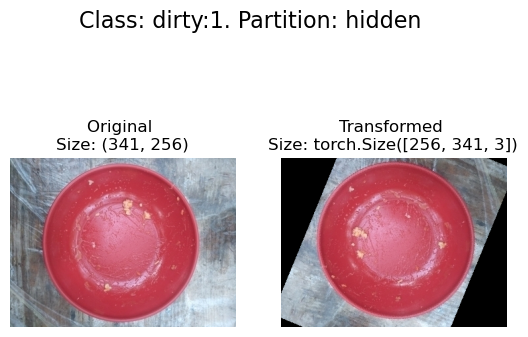

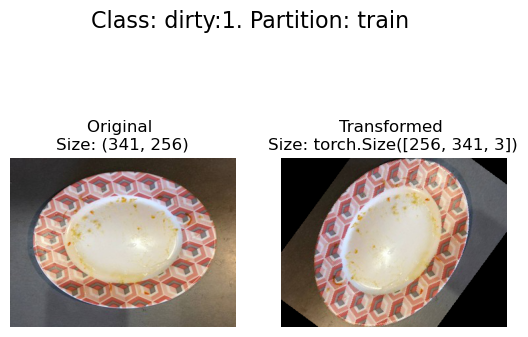

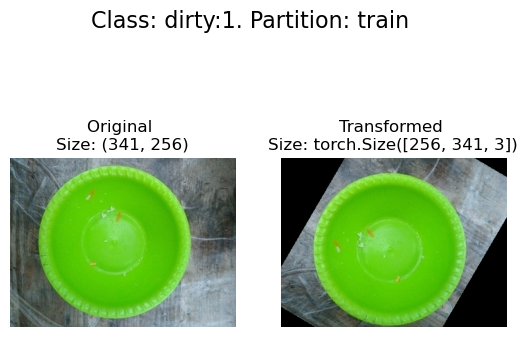

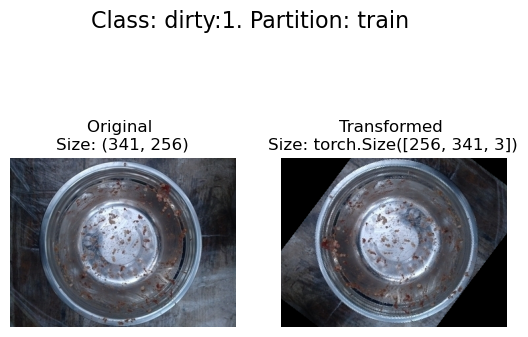

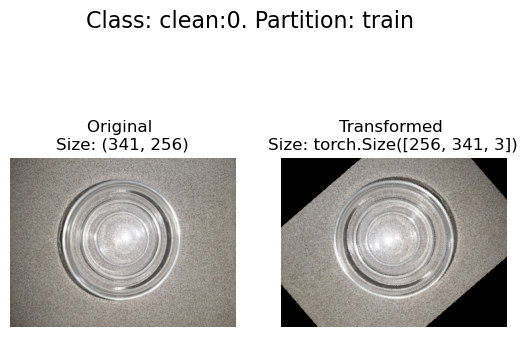

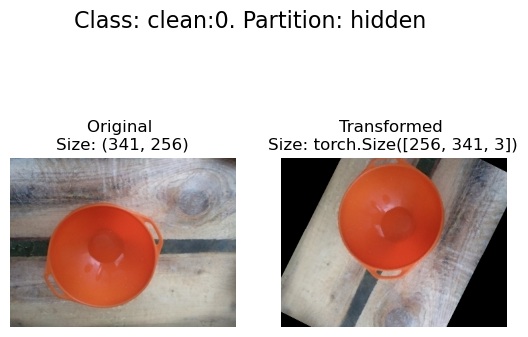

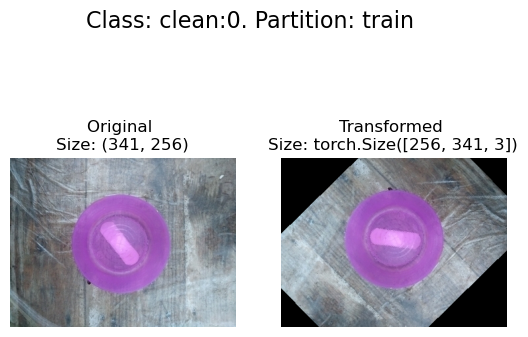

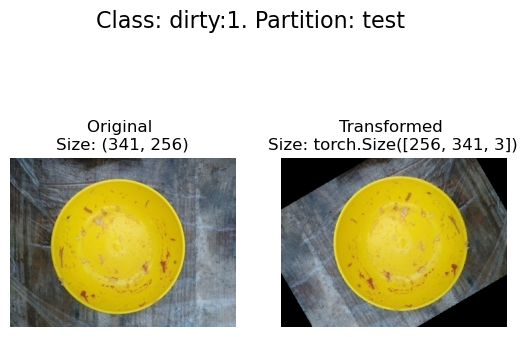

In [16]:
ImageTransformer.plot_transformed_images(_ALL_ITEMS_, transform=full_transform, n=10)

## Create data loader

In [17]:
train_path = Path(clean_train[0].full_path).parent.parent
test_path = Path(clean_test[0].full_path).parent.parent

## Create model

In [18]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [19]:
class ModelTrainer:
    
    def train_step(model: torch.nn.Module, 
                   dataloader: torch.utils.data.DataLoader, 
                   loss_fn: torch.nn.Module, 
                   optimizer: torch.optim.Optimizer):
    
        device = CudaHelper.get_device()

        # Put model in train mode
        model.train()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):
            
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            #print(f'Tensor: {X.shape}')
            
            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item() 

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch 
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)
        return train_loss, train_acc

    def test_step(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  loss_fn: torch.nn.Module):

        device = CudaHelper.get_device()

        # Put model in eval mode
        model.eval() 

        # Setup test loss and test accuracy values
        test_loss, test_acc = 0, 0

        # Turn on inference context manager
        with torch.inference_mode():
            
            # Loop through DataLoader batches
            for batch, (X, y) in enumerate(dataloader):
                
                # Send data to target device
                X, y = X.to(device), y.to(device)

                # 1. Forward pass
                test_pred_logits = model(X)

                # 2. Calculate and accumulate loss
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()

                # Calculate and accumulate accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch 
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc
    
    # 1. Take in various parameters required for training and test steps
    def train(model: torch.nn.Module, 
              train_dataloader: torch.utils.data.DataLoader, 
              test_dataloader: torch.utils.data.DataLoader, 
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
              epochs: int = 5):
    
        # 2. Create empty results dictionary
        results = {"train_loss": [],
                   "train_acc": [],
                   "test_loss": [],
                   "test_acc": []
        }

        # 3. Loop through training and testing steps for a number of epochs
        for epoch in range(epochs):
            
            train_loss, train_acc = ModelTrainer.train_step(model=model,
                                               dataloader=train_dataloader,
                                               loss_fn=loss_fn,
                                               optimizer=optimizer)

            test_loss, test_acc = ModelTrainer.test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn)

            # 4. Print out what's happening
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

            # 5. Update results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

        # 6. Return the filled results at the end of the epochs
        return results

    def plot_loss_curves(results: dict[str, list[float]], title: str):

        # Get the loss values of the results dictionary (training and test)
        loss = results['train_loss']
        test_loss = results['test_loss']

        # Get the accuracy values of the results dictionary (training and test)
        accuracy = results['train_acc']
        test_accuracy = results['test_acc']

        # Figure out how many epochs there were
        epochs = range(len(results['train_loss']))

        # Setup a plot 
        fig = plt.figure(figsize=(15, 7))
        fig.suptitle(title, fontsize=30)

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, label='train_loss')
        plt.plot(epochs, test_loss, label='test_loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label='train_accuracy')
        plt.plot(epochs, test_accuracy, label='test_accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.legend();
    
    def plot_loss_curves_multi_sources(results: dict[dict[str, list[float]]], title: str):
        
        fig = plt.figure(figsize=(15, 7))
        fig.suptitle(title, fontsize=30)

        # Plot loss
        plt.subplot(1, 2, 1)
        for result in results.items():
            loss = result[1]['train_loss']
            test_loss = result[1]['test_loss']
            epochs = range(len(result[1]['train_loss']))
            plt.plot(epochs, loss, label=f'{result[0]} train_loss')
            plt.plot(epochs, test_loss, label=f'{result[0]} test_loss')        
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        for result in results.items():
            accuracy = result[1]['train_acc']
            test_accuracy = result[1]['test_acc']
            epochs = range(len(result[1]['test_acc']))
            plt.plot(epochs, accuracy, label=f'{result[0]} train_accuracy')
            plt.plot(epochs, test_accuracy, label=f'{result[0]} test_accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.legend();
        
    def pred_and_plot_image(model: torch.nn.Module, 
                            image_path: str, 
                            class_names: list[str] = None, 
                            transform=None):
        
        device = CudaHelper.get_device()
        
        # 1. Load in image and convert the tensor values to float32
        target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

        # 2. Divide the image pixel values by 255 to get them between [0, 1]
        target_image = target_image / 255. 

        # 3. Transform if necessary
        if transform:
            target_image = transform(target_image)

        # 4. Make sure the model is on the target device
        model.to(device)

        # 5. Turn on model evaluation mode and inference mode
        model.eval()
        with torch.inference_mode():
            # Add an extra dimension to the image
            target_image = target_image.unsqueeze(dim=0)

            # Make a prediction on image with an extra dimension and send it to the target device
            target_image_pred = model(target_image.to(device))

        # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 7. Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        # 8. Plot the image alongside the prediction and prediction probability
        plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
        if class_names:
            title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else: 
            title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        plt.title(title)
        plt.axis(False);

In [20]:
class ModelFactory:
    
    def build_tinyvgg_model(image_transforms, num_hidden_units, create_loss, create_optimizer, title):
        func = lambda: ModelFactory.build_tinyvgg_model_impl(image_transforms, num_hidden_units, create_loss, create_optimizer, title)
        return func
    
    def build_densenet201(image_transforms, create_loss, create_optimizer, title):
        func = lambda: ModelFactory.build_densenet201_impl(image_transforms, create_loss, create_optimizer, title)
        return func       
    
    def build_google(image_transforms, create_loss, create_optimizer, title):
        func = lambda: ModelFactory.build_google_impl(image_transforms, create_loss, create_optimizer, title)
        return func   
    
    def build_google_impl(image_transforms, create_loss, create_optimizer, title):
        
        NUM_EPOCHS = 10
        _BATCH_SIZE_ = 20
        _NUM_WORKERS_ = os.cpu_count()

        train_data = datasets.ImageFolder(root=train_path, transform=image_transforms)
        test_data = datasets.ImageFolder(root=test_path, transform=image_transforms) 

        train_dataloader = DataLoader(dataset=train_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=True, pin_memory=True) 
        test_dataloader = DataLoader(dataset=test_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=False, pin_memory=True)

        # build model
        model_google = torchvision.models.googlenet(weights='DEFAULT').to(CudaHelper.get_device())

        for param in model_google.parameters():
            param.requires_grad = False

        model_google.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=True), 
            torch.nn.Linear(in_features=1024, 
                    out_features=len(img_class_name),
                    bias=True)).to(CudaHelper.get_device())
        
        
        loss_fn = create_loss()
        optimizer = create_optimizer(model_google.parameters())

        start_time = timer()
        model_google_results = ModelTrainer.train(model_google, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS)
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds. Mean epoch: {(end_time-start_time)/NUM_EPOCHS}")

        return model_google, model_google_results, title
    
    
    def build_densenet201_impl(image_transforms, create_loss, create_optimizer, title):
        
        NUM_EPOCHS = 10
        _BATCH_SIZE_ = 20
        _NUM_WORKERS_ = os.cpu_count()

        train_data = datasets.ImageFolder(root=train_path, transform=image_transforms)
        test_data = datasets.ImageFolder(root=test_path, transform=image_transforms) 

        train_dataloader = DataLoader(dataset=train_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=True, pin_memory=True) 
        test_dataloader = DataLoader(dataset=test_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=False, pin_memory=True)

        # build model
        model_densenet201 = torchvision.models.densenet201(weights='DEFAULT').to(CudaHelper.get_device())
        
        for param in model_densenet201.parameters():
            param.requires_grad = False
            
        model_densenet201.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=True), 
            torch.nn.Linear(in_features=1920, 
                    out_features=len(img_class_name),
                    bias=True)).to(CudaHelper.get_device())
        
        
        loss_fn = create_loss()
        optimizer = create_optimizer(model_densenet201.parameters())

        start_time = timer()
        model_densenet201_results = ModelTrainer.train(model_densenet201, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS)
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds. Mean epoch: {(end_time-start_time)/NUM_EPOCHS}")

        return model_densenet201, model_densenet201_results, title
    
    def build_tinyvgg_model_impl(image_transforms, num_hidden_units, create_loss, create_optimizer, title):
        
        NUM_EPOCHS = 10
        _BATCH_SIZE_ = 20
        _NUM_WORKERS_ = os.cpu_count()

        train_data = datasets.ImageFolder(root=train_path, transform=image_transforms)
        test_data = datasets.ImageFolder(root=test_path, transform=image_transforms) 

        train_dataloader = DataLoader(dataset=train_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=True, pin_memory=True) 
        test_dataloader = DataLoader(dataset=test_data, batch_size=_BATCH_SIZE_, num_workers=_NUM_WORKERS_, shuffle=False, pin_memory=True)

        # build model
        model_0 = TinyVGG(input_shape=3, hidden_units=num_hidden_units, output_shape=len(train_data.classes)).to(CudaHelper.get_device())
        loss_fn = create_loss()
        optimizer = create_optimizer(model_0.parameters())

        start_time = timer()
        model_0_results = ModelTrainer.train(model_0, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS)
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds. Mean epoch: {(end_time-start_time)/NUM_EPOCHS}")

        return model_0, model_0_results, title
    

In [21]:
class ModelPersister:
    
    def save_to_disk(all_results, all_trained_models):
    
        keys = list(all_results.keys())
        
        for i in range(len(keys)):    
            with open(f'{keys[i]}.pkl', 'wb') as fp:
                pickle.dump(all_trained_models[keys[i]], fp)

        with open('all_results_data.pkl', 'wb') as fp:
            pickle.dump(all_results, fp)
            
    def load_all_data_from_disk(all_data_path):

        with open(all_data_path, 'rb') as fp:
            all_results = pickle.load(fp)

        return all_results
    
               
    def load_model_from_disk(model_path):

        with open(model_path, 'rb') as fp:
            model = pickle.load(fp)

        return model
    

In [22]:
all_results = {}
all_trained_models = {}
    
model_0 = ModelFactory.build_tinyvgg_model(simple_transform, 10,
                                     lambda: nn.CrossEntropyLoss(),
                                     lambda p: torch.optim.Adam(params=p, lr=0.001),
                                     'Tiny VGG - hidden layers - 10 - adam')

model_1 = ModelFactory.build_tinyvgg_model(simple_transform, 20,
                                     lambda: nn.CrossEntropyLoss(),
                                     lambda p: torch.optim.Adam(params=p, lr=0.001),
                                     'Tiny VGG - hidden layers - 20 - adam')
    
model_2 = ModelFactory.build_tinyvgg_model(simple_transform, 10,
                                    lambda: nn.CrossEntropyLoss(),
                                    lambda p: torch.optim.AdamW(params=p, lr=0.001),
                                    'Tiny VGG - hidden layers - 10 - AdamW')
   
model_3 = ModelFactory.build_tinyvgg_model(simple_transform, 10,
                                    lambda: nn.CrossEntropyLoss(),
                                    lambda p: torch.optim.ASGD(params=p, lr=0.001),
                                    'Tiny VGG - hidden layers - 10 - ASGD')
    
model_4 = ModelFactory.build_densenet201(simple_transform,
                                         lambda: nn.CrossEntropyLoss(),
                                         lambda p: torch.optim.Adam(params=p, lr=0.001),
                                         'DenseNET - adam')

model_5 = ModelFactory.build_google(simple_transform,
                                    lambda: nn.CrossEntropyLoss(),
                                    lambda p: torch.optim.Adam(params=p, lr=0.001),
                                    'GoogleNET adam')

experiments = [ model_1, model_4, model_5 ]

In [23]:
for experiment in experiments:
    model, result, title = experiment()
    all_results[title] = result
    all_trained_models[title] = model

Epoch: 1 | train_loss: 0.6964 | train_acc: 0.5267 | test_loss: 0.7228 | test_acc: 0.3261
Epoch: 2 | train_loss: 0.6934 | train_acc: 0.5367 | test_loss: 0.6882 | test_acc: 0.7217
Epoch: 3 | train_loss: 0.6800 | train_acc: 0.6533 | test_loss: 0.6387 | test_acc: 0.8130
Epoch: 4 | train_loss: 0.6250 | train_acc: 0.6833 | test_loss: 0.4737 | test_acc: 0.6826
Epoch: 5 | train_loss: 0.5925 | train_acc: 0.6667 | test_loss: 0.3543 | test_acc: 0.8565
Epoch: 6 | train_loss: 0.5294 | train_acc: 0.7133 | test_loss: 0.3710 | test_acc: 0.8304
Epoch: 7 | train_loss: 0.5177 | train_acc: 0.7433 | test_loss: 0.3894 | test_acc: 0.8239
Epoch: 8 | train_loss: 0.5001 | train_acc: 0.7167 | test_loss: 0.3173 | test_acc: 0.8630
Epoch: 9 | train_loss: 0.5001 | train_acc: 0.7400 | test_loss: 0.3219 | test_acc: 0.8565
Epoch: 10 | train_loss: 0.5405 | train_acc: 0.7100 | test_loss: 0.3406 | test_acc: 0.8630
Total training time: 374.929 seconds. Mean epoch: 37.49293772000092
Epoch: 1 | train_loss: 0.6985 | train_acc

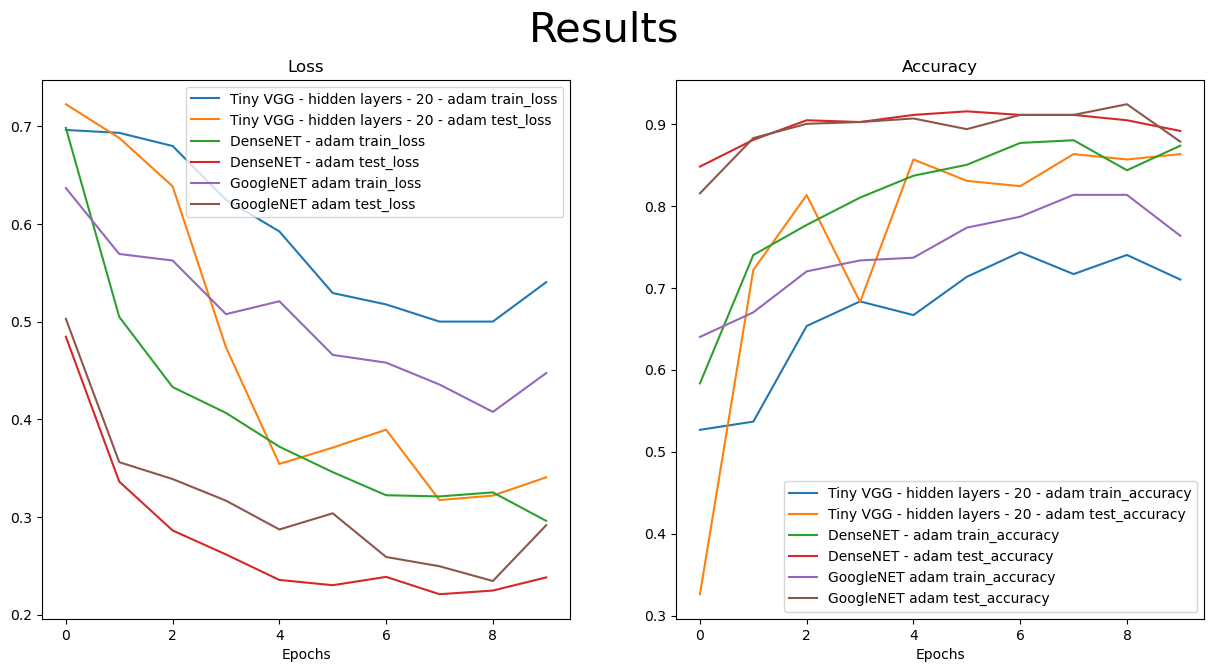

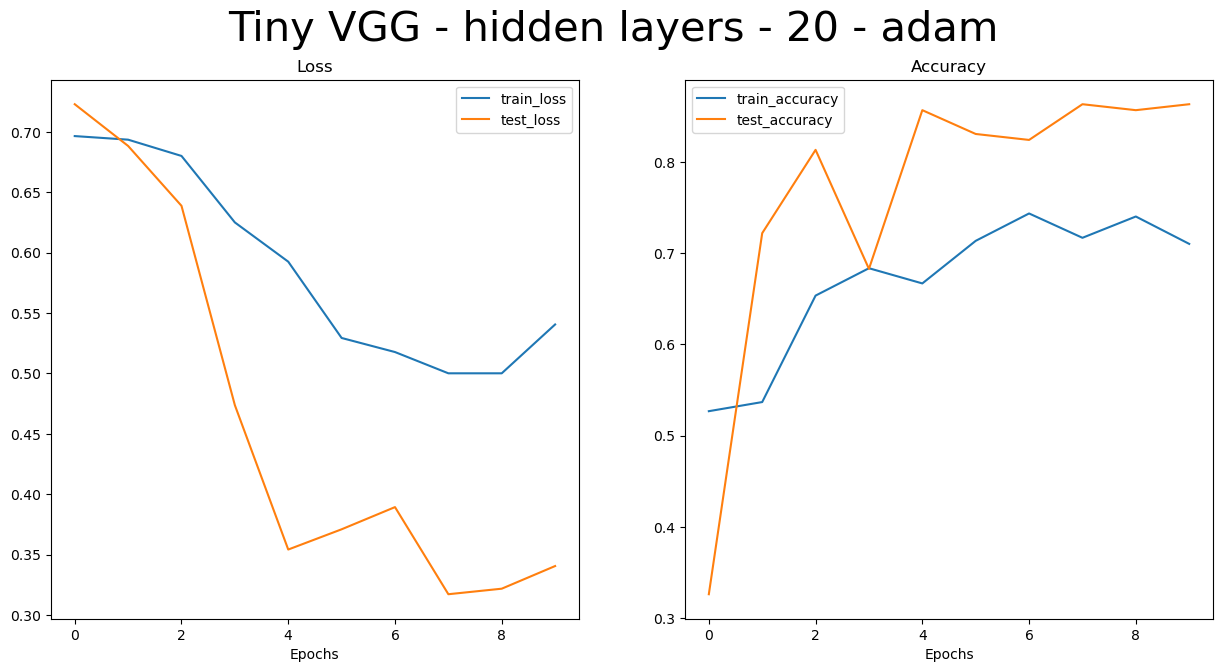

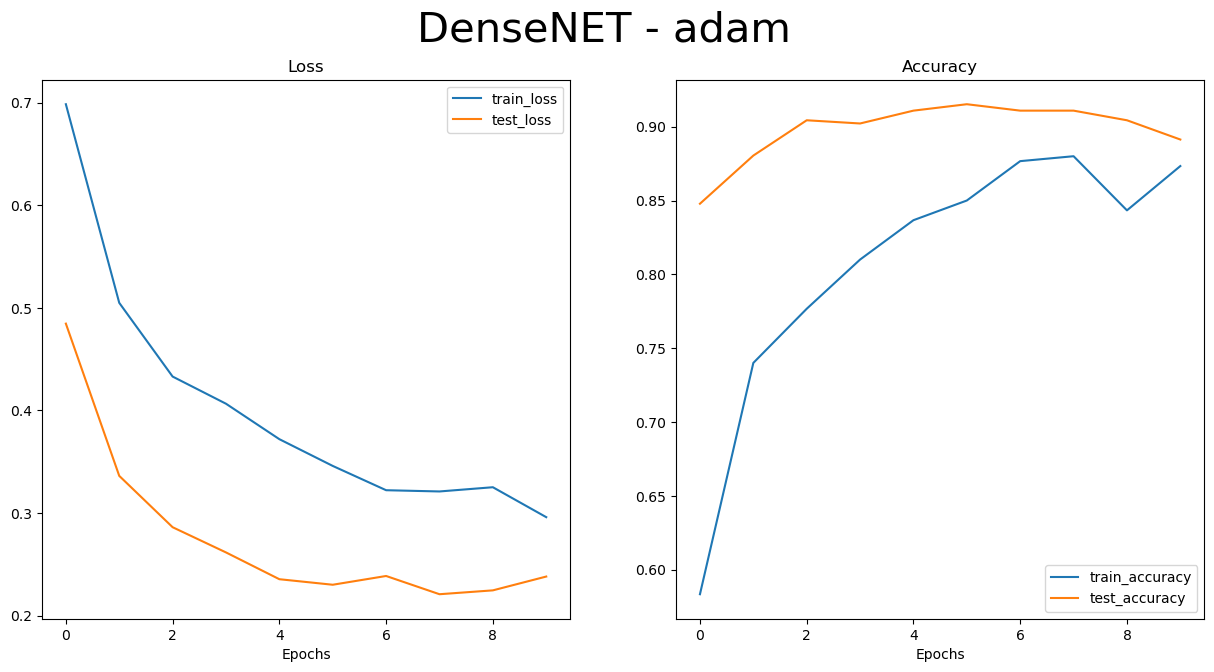

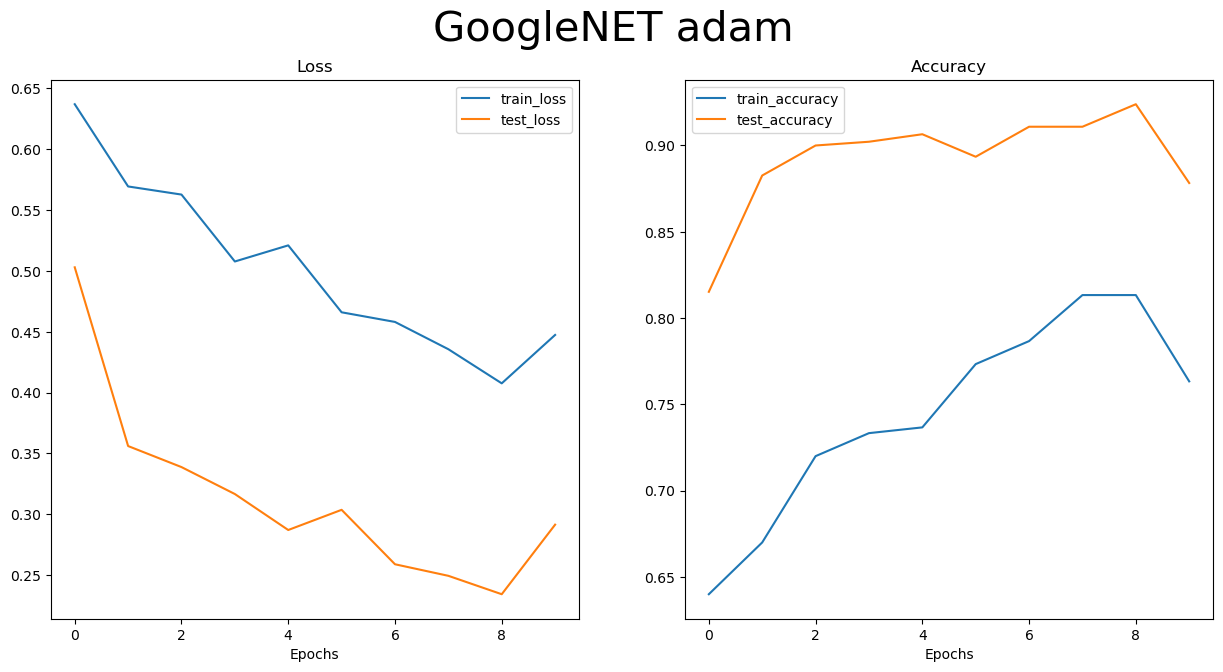

In [24]:
ModelTrainer.plot_loss_curves_multi_sources(all_results, 'Results')

for result in all_results.items():
    ModelTrainer.plot_loss_curves(result[1], result[0])

In [25]:
#all_results, model = ModelPersister.load_all_data_from_disk()
#ModelTrainer.plot_loss_curves_multi_sources(all_results, 'Results')

AttributeError: type object 'ModelPersister' has no attribute 'load_from_disk'

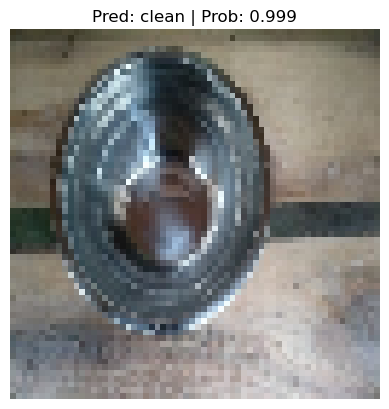

In [28]:
test_image_path = 'C:\\Users\\Valentine\\Downloads\\NeuralNetworks\\plates\\plates\\test\\clean\\1001.jpg'

ModelTrainer.pred_and_plot_image(model = model, 
                                 image_path = test_image_path,
                                 class_names = ['clean', 'dirty'],
                                 transform = simple_transform_no_tensor)

## Build confusion matrix

In [29]:
model_from_disk = ModelPersister.load_model_from_disk('Tiny VGG - hidden layers - 20 - adam.pkl')